###Système de recommendation :
Les systèmes de recommandation sont des logiciels et des méthodes utilisés pour filtrer de grandes quantités d'informations et proposer des produits ou des services particuliers aux utilisateurs qui sont très susceptibles de les apprécier, ce qui entraîne une évaluation élevée. Par conséquent, ils sont utilisés dans de nombreuses industries commerciales, notamment les films, les nouvelles, les livres, la musique et autres. Il existe de nombreuses méthodes différentes pour créer un système de recommandation, y compris les méthodes naives, dans lesquelles le système calcule la note moyenne d'un item en fonction de la note moyenne d'un autre utilisateur ou de la note moyenne d'un même utilisateur, puis suggère un item avec une note moyenne relativement élevée. Avec des méthodes plus sophistiquées, telles que le filtrage collaboratif, les mêmes articles sont suggérés pour les "comparables" utilisateurs, qui ont tendance à apprécier les mêmes articles et ont des préférences communes. Avec l'approche basée sur le contenu, des articles sont suggérés à un utilisateur parce qu'ils avaient apprécié des articles similaires auparavant. Finalement, d'autres méthodes comprennent la factorisation matricielle, comme la décomposition de valeur unique.

###Matrice de Factorisation :

Ce projet consiste en une implémentation en PyTorch de la technique de factorisation de matrice. La matrice de factorisation, également connue sous le nom de factorisation matricielle, est une technique clé dans le domaine de l'algèbre linéaire et de l'apprentissage automatique. Elle vise à décomposer une matrice complexe en plusieurs matrices plus simples, facilitant ainsi la compréhension et l'analyse de ses composants sous-jacents. La factorisation de matrices dans le contexte de systèmes de recommandation, où une matrice d'évaluations utilisateur-film est décomposée en deux matrices, souvent appelées matrices utilisateur et matrices film. Ces matrices résultantes encapsulent des caractéristiques latentes qui décrivent les préférences des utilisateurs et les attributs des films. La factorisation de matrices est largement utilisée pour traiter des ensembles de données complexes et volumineux, offrant une méthode efficace pour extraire des informations significatives à partir de structures matricielles intricquées.

In [189]:
# Data Citation:
# F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on
# Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>

! curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  3875k      0 --:--:-- --:--:-- --:--:-- 3867k


In [190]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from tqdm import tqdm_notebook as tqdm

from sklearn import model_selection, metrics, preprocessing
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [191]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [192]:
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [193]:
movies_df = pd.read_csv('data/ml-latest-small/movies.csv')
rating_df = pd.read_csv('data/ml-latest-small/ratings.csv')

###Exploration des données

In [194]:
print('La dimension du dataframe movies est:', movies_df.shape,'\nLa dimension du dataframe ratings est:', rating_df.shape)

La dimension du dataframe movies est: (9742, 3) 
La dimension du dataframe ratings est: (100836, 4)


In [195]:
rating_df .info() # basically show schema

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [196]:
# Take a look at movies_df
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [197]:
# Take a look at ratings_df
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [198]:
# Convert values in 'Column_Name' to strings and join using '|'
result = movies_df['genres'].str.cat(sep='|')

# Split the string into a list of substrings using '|'
split_strings = result.split('|')

# Convert the list of substrings into a set to eliminate duplicates
unique_strings = set(split_strings)

print(unique_strings)

{'Sci-Fi', 'Film-Noir', 'Crime', 'Action', 'Mystery', 'Drama', 'Musical', 'War', 'Animation', 'Comedy', 'Fantasy', 'IMAX', 'Horror', 'Western', 'Thriller', 'Documentary', '(no genres listed)', 'Romance', 'Children', 'Adventure'}


A partir de ces résultats on remarque qu'on a 20 genres (caractéristiques de films dans notre dataset). Ceci peut nous donner une idée sur le nombre de caractéristiques de la matrice des Users et la matrice Movies.

=> On le fixe à 20 caractéristiques

In [199]:
# Movie ID to movie name mapping
movie_names = movies_df.set_index('movieId')['title'].to_dict()
n_users = len(rating_df.userId.unique())
n_items = len(rating_df.movieId.unique())
print("Number of unique users:", n_users)
print("Number of unique movies:", n_items)
print("The full rating matrix will have:", n_users*n_items, 'elements.')
print('----------')
print("Number of ratings:", len(rating_df))
print("Therefore: ", len(rating_df) / (n_users*n_items) * 100, '% of the matrix is filled.')

Number of unique users: 610
Number of unique movies: 9724
The full rating matrix will have: 5931640 elements.
----------
Number of ratings: 100836
Therefore:  1.6999683055613624 % of the matrix is filled.


*   Nous avons ici une matrice incroyablement sparse (peu dense) avec laquelle nous travaillerons.
*   Comme nous pouvons l'imaginer, à mesure que le nombre d'utilisateurs et de films augmente, le nombre d'éléments va croître de n*2.
Nous aurons besoin de beaucoup de mémoire pour travailler à l'échelle globale.
* Stocker une matrice complète en mémoire serait un défi.
* Un avantage ici est que la factorisation matricielle peut réaliser implicitement la matrice d'évaulation, ainsi nous n'avons pas besoin de toutes les données.

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64


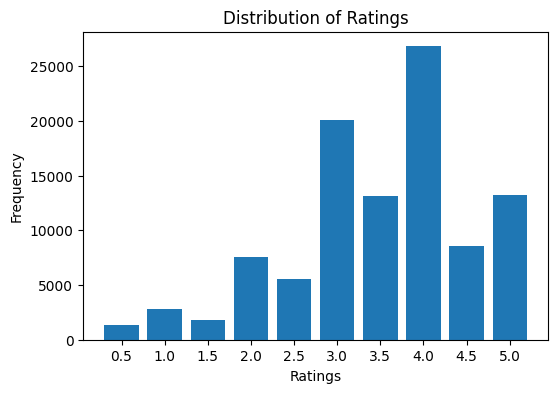

In [200]:
print(rating_df.rating.value_counts()) #check value distribution)

# Assuming 'df' is the name of your DataFrame and 'rating' is the column you want to plot
ratings_counts = rating_df['rating'].value_counts()

# Create a histogram with slightly separated bars
plt.figure(figsize=(6, 4))
plt.bar(ratings_counts.index, ratings_counts.values, width=0.4, align='center')  # Adjust the width as needed

plt.xticks(np.arange(0.5,5.5,0.5))

# Set labels and title
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')

# Show plot
plt.show()

 Ce graphe représente la distribution des évaluations attribuées par les utilisateurs aux films. En regardant les nombres, on peut dire que les évaluations les plus fréquentes sont 4.0, 3.0, 5.0 et 3.5. Cela suggère que la majorité des évaluations se situent dans cette plage. Les évaluations extrêmes, comme 0.5, 1.0 et 1.5, sont moins fréquentes, indiquant que les utilisateurs sont moins enclins à donner des notes très basses. Cela peut suggérer qu'en général, les films reçoivent des évaluations plus positives que négatives, mais la majorité des évaluations se concentrent autour de quelques valeurs spécifiques.

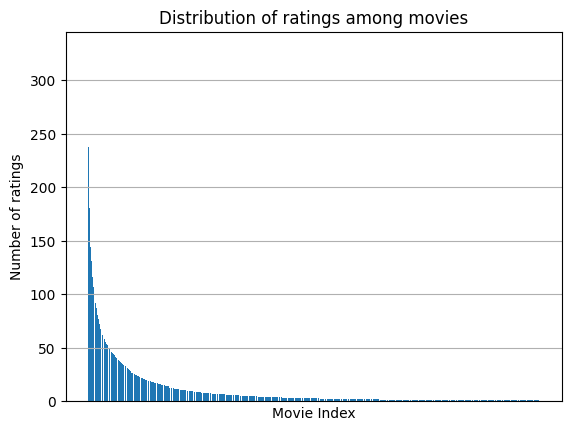

In [201]:
#Q3 - Distribution of ratings among movies

plt.title('Distribution of ratings among movies')
plt.xlabel('Movie Index')
plt.ylabel('Number of ratings')
plt.grid('True')

# Sort movie ratings in decreasing order of ratings
ctr_movieratings = Counter(rating_df['movieId'])
plt.xticks([], [])
plt.bar(np.arange(n_items),sorted(ctr_movieratings.values(),reverse = True))


plt.show()

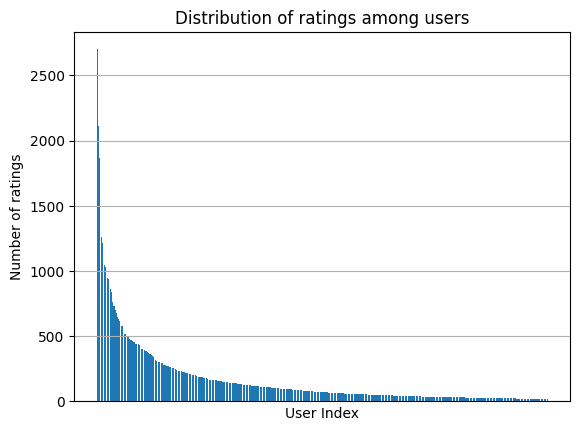

In [202]:
#Q3 -- Distribution of ratings among users

plt.title('Distribution of ratings among users')
plt.xlabel('User Index')
plt.ylabel('Number of ratings')
plt.grid('True')

# Sort user ratings in decreasing order of ratings
ctr_userratings = Counter(rating_df['userId'])
plt.xticks([], [])
plt.bar(np.arange(n_users),sorted(ctr_userratings.values(),reverse = True))


plt.show()

###Dataset Class

In [203]:
class MovieDataset:
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings
    # len(movie_dataset)
    def __len__(self):
        return len(self.users)
    # movie_dataset[1]
    def __getitem__(self, item):

        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }


Cette classe est conçue pour préparer et fournir les données du jeu de données des films pour être utilisées dans un modèle de recommandation .

En résumé, cette classe facilite la transformation et l'accès aux données du jeu de données des films en les préparant sous forme de tenseurs PyTorch pour être utilisées efficacement dans un modèle d'apprentissage automatique.

###Model Class

In [204]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors

        self.user_embed = nn.Embedding(n_users, 20)
        self.movie_embed = nn.Embedding(n_movies, 20)
        # user, movie embedding concat
        self.out = nn.Linear(40, 1)


    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.cat([user_embeds, movie_embeds], dim=1)

        output = self.out(output)

        return output

Cette classe définit le modèle à utiliser pour la factorisation matricielle. Ce modèle utilise la factorisation matricielle avec des couches d'Embedding pour représenter les utilisateurs et les films, permettant ainsi de prédire les notes de films pour les utilisateurs.  Ces couches d'embedding sont des matrices apprises qui représentent les utilisateurs et les films sous forme de vecteurs d'une dimension spécifique (20 dans ce cas). La couche de sortie (Linear) concatène ces vecteurs pour obtenir une prédiction de note.

###Load Training Data and Validation Data

In [205]:
# encode the user and movie id to start from 0 so we don't run into index out of bound with Embedding
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)


# split data into train data and validation data
df_train, df_valid = model_selection.train_test_split(
    rating_df, test_size=0.1, random_state=42, stratify=rating_df.rating.values
)


train_dataset = MovieDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values
)

valid_dataset = MovieDataset(
    users=df_valid.userId.values,
    movies=df_valid.movieId.values,
    ratings=df_valid.rating.values
)

# define loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True)

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True)

###Define model

In [206]:
model = MatrixFactorization(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_),
).to(device)

print(model)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

optimizer = torch.optim.Adam(model.parameters())
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

MatrixFactorization(
  (user_embed): Embedding(610, 20)
  (movie_embed): Embedding(9724, 20)
  (out): Linear(in_features=40, out_features=1, bias=True)
)
user_embed.weight tensor([[-0.7431,  0.7342,  0.7980,  ..., -0.8426, -0.5591, -0.5896],
        [-0.3136, -1.2170, -2.2544,  ..., -0.6124, -0.4057, -0.9894],
        [-0.3877, -0.0815,  0.6416,  ..., -0.9793,  1.1844, -0.0814],
        ...,
        [-1.4812,  0.0366, -0.6953,  ...,  0.2440,  1.0742, -1.4564],
        [-1.3460, -1.5090, -0.1371,  ...,  0.8553, -0.6957,  0.5939],
        [-0.0727,  0.0234, -0.0174,  ...,  0.1651, -1.2719,  0.4223]])
movie_embed.weight tensor([[ 0.2763,  1.1535,  0.4878,  ..., -1.2415, -0.4988,  0.6437],
        [ 0.2861,  0.5942,  0.2476,  ...,  0.0522,  0.7272, -0.5372],
        [ 0.8671,  0.6541, -0.2409,  ...,  0.2451, -1.8567, -1.1097],
        ...,
        [ 1.1047,  0.0720, -0.9979,  ...,  1.5231,  0.7403, -0.5265],
        [ 0.0714, -2.2203, -0.6201,  ...,  0.2401, -1.6066, -0.1090],
        [ 0.

#### Run the training loop

In [207]:
epochs = 5
total_loss = 0
plot_steps, print_steps = 5000, 5000
all_losses_list = []

model.train()

for epoch_i in tqdm(range(epochs)):
    step_cnt=0
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"],
                       train_data["movies"]
                      )


        # .view(4, -1) is to reshape the rating to match the shape of model output which is 4x1
        rating = train_data["ratings"].view(4, -1).to(torch.float32)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt += len(train_data["users"])


        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss

<ipython-input-207-feb19786a403>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch_i in tqdm(range(epochs)):


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0 loss at step: 5000 is 0.5297440351948142
epoch 0 loss at step: 10000 is 0.20273462382629515
epoch 0 loss at step: 15000 is 0.11659554279837757
epoch 0 loss at step: 20000 is 0.08936772007532418
epoch 0 loss at step: 25000 is 0.07694058140460401
epoch 0 loss at step: 30000 is 0.06792794766835869
epoch 0 loss at step: 35000 is 0.06546083782501519
epoch 0 loss at step: 40000 is 0.06530711475526914
epoch 0 loss at step: 45000 is 0.061045929143927063
epoch 0 loss at step: 50000 is 0.0612425698726438
epoch 0 loss at step: 55000 is 0.061603370175696906
epoch 0 loss at step: 60000 is 0.061520783884776754
epoch 0 loss at step: 65000 is 0.05919225642420352
epoch 0 loss at step: 70000 is 0.056057089988328514
epoch 0 loss at step: 75000 is 0.05757401609602384
epoch 0 loss at step: 80000 is 0.0591733498075977
epoch 0 loss at step: 85000 is 0.05772671584892087
epoch 0 loss at step: 90000 is 0.056621728286147116
epoch 1 loss at step: 5000 is 0.06478723152205348
epoch 1 loss at step: 10000 is 

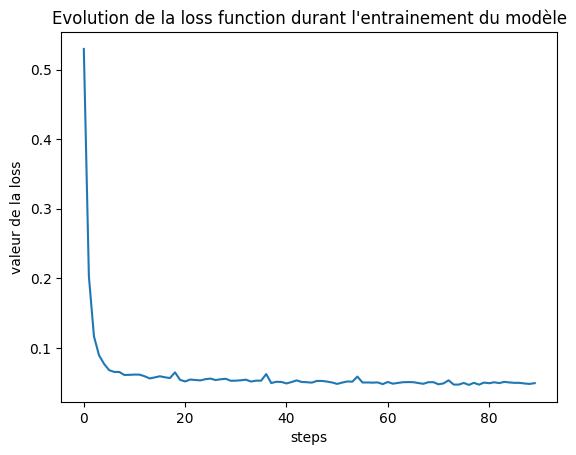

In [208]:
plt.figure()
plt.plot(all_losses_list)

plt.title("Evolution de la loss function durant l'entrainement du modèle")
plt.xlabel('steps')
plt.ylabel('valeur de la loss')

plt.show()


Ce graphe montre l'évolution de la fonction perte moyenne pendant l'entraînement du modèle sur plusieurs époques (epochs) et étapes (steps). Lorsqu'on observe ces données, on remarque que la fonction perte diminue de manière significative à travers les époques, passant d'une perte initiale plus élevée à une perte plus faible à chaque étape.

### RMSE Measure


In [209]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        model_output = model(batched_data['users'],
                       batched_data["movies"])

        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data["ratings"]

        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))



# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"RMSE: {rms}")

RMSE: 0.4566902836867807


### Recall@K and Precision@K Measures


In [210]:
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user
user_est_true = defaultdict(list)

# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        users = batched_data['users']
        movies = batched_data['movies']
        ratings = batched_data['ratings']

        model_output = model(batched_data['users'], batched_data["movies"])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()

            print(f"User: {user_id},  Movie: {movie_id}, Predicted_rating: {pred_rating}, Reel_rating: {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))


Streaming output truncated to the last 5000 lines.
User: 159,  Movie: 370, Predicted_rating: 2.4120607376098633, Reel_rating: 3
User: 103,  Movie: 1317, Predicted_rating: 2.9054226875305176, Reel_rating: 4
User: 593,  Movie: 3673, Predicted_rating: 3.974459409713745, Reel_rating: 5
User: 317,  Movie: 1266, Predicted_rating: 3.6979823112487793, Reel_rating: 4
User: 228,  Movie: 156, Predicted_rating: 3.270261764526367, Reel_rating: 4
User: 531,  Movie: 1767, Predicted_rating: 4.024274826049805, Reel_rating: 4
User: 473,  Movie: 1662, Predicted_rating: 3.3144025802612305, Reel_rating: 3
User: 43,  Movie: 592, Predicted_rating: 3.577948570251465, Reel_rating: 5
User: 287,  Movie: 1720, Predicted_rating: 3.5332183837890625, Reel_rating: 3
User: 461,  Movie: 9069, Predicted_rating: 2.3887112140655518, Reel_rating: 2
User: 586,  Movie: 1062, Predicted_rating: 3.7275633811950684, Reel_rating: 3
User: 579,  Movie: 3226, Predicted_rating: 2.55955171585083, Reel_rating: 4
User: 168,  Movie: 10, 

In [211]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k=10
    threshold=3.5

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value.
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        print(f"User : {uid},  n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

User : 451,  n_rel 27, n_rec_k 10, n_rel_and_rec_k 10
User : 0,  n_rel 24, n_rec_k 10, n_rel_and_rec_k 10
User : 311,  n_rel 17, n_rec_k 10, n_rel_and_rec_k 9
User : 253,  n_rel 10, n_rec_k 9, n_rel_and_rec_k 8
User : 255,  n_rel 19, n_rec_k 10, n_rel_and_rec_k 8
User : 248,  n_rel 56, n_rec_k 10, n_rel_and_rec_k 10
User : 482,  n_rel 49, n_rec_k 10, n_rel_and_rec_k 8
User : 225,  n_rel 18, n_rec_k 10, n_rel_and_rec_k 10
User : 566,  n_rel 2, n_rec_k 0, n_rel_and_rec_k 0
User : 605,  n_rel 65, n_rec_k 10, n_rel_and_rec_k 7
User : 144,  n_rel 1, n_rec_k 0, n_rel_and_rec_k 0
User : 5,  n_rel 16, n_rec_k 10, n_rel_and_rec_k 5
User : 62,  n_rel 16, n_rec_k 10, n_rel_and_rec_k 6
User : 379,  n_rel 66, n_rec_k 10, n_rel_and_rec_k 9
User : 209,  n_rel 14, n_rec_k 10, n_rel_and_rec_k 8
User : 273,  n_rel 28, n_rec_k 10, n_rel_and_rec_k 5
User : 19,  n_rel 8, n_rec_k 8, n_rel_and_rec_k 3
User : 259,  n_rel 10, n_rec_k 8, n_rel_and_rec_k 5
User : 559,  n_rel 22, n_rec_k 10, n_rel_and_rec_k 7
Use

In [212]:
# Precision and recall can then be averaged over all users
print(f"Precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"Recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")


Precision @ 10: 0.611131613756614
Recall @ 10 : 0.5250849702874602


La précision et le rappel sont deux mesures importantes pour évaluer la qualité des recommandations fournies par un modèle.

Precision @ 10 (Précision à 10) : Cette métrique mesure la proportion d'éléments pertinents parmi les 10 premiers éléments recommandés par le modèle. Une valeur de 0.611 signifie que sur les 10 éléments recommandés, environ 6 sont pertinents selon les critères définis. C'est une mesure de la qualité des recommandations dans les 10 premiers éléments.

Recall @ 10 (Rappel à 10) : Cette métrique évalue la proportion d'éléments pertinents parmi tous les éléments réellement pertinents, dans les 10 premiers éléments recommandés. Un score de 0.525 indique que sur tous les éléments réellement pertinents qui auraient dû être recommandés dans les 10 premiers, environ 52% d'entre eux ont effectivement été recommandés. C'est une mesure de la sensibilité du modèle à trouver les éléments pertinents.

Ces deux métriques donnent une indication sur la capacité du modèle à recommander des éléments pertinents parmi les premières propositions.

###AUC Measure

In [213]:
from sklearn.metrics import roc_auc_score

# Lists to store true ratings and predicted scores
true_ratings_list = []
predicted_scores_list = []

threshold = 3.5  # Threshold for considering a rating relevant

# Loop through users in your dataset
for uid, user_ratings in user_est_true.items():
    # Sort user ratings by estimated value.
    user_ratings.sort(key=lambda x: x[0], reverse=True)

    # Extract true ratings and predicted scores
    true_ratings = [true_r >= threshold for (_, true_r) in user_ratings]  # Consider relevant if >= threshold
    predicted_scores = [est for (est, _) in user_ratings]

    # Add true ratings and predicted scores to the lists
    true_ratings_list.extend(true_ratings)
    predicted_scores_list.extend(predicted_scores)

# Calculate AUC using true ratings and predicted scores
auc = roc_auc_score(true_ratings_list, predicted_scores_list)
print(f"AUC: {auc}")

AUC: 0.776362589623375


L'AUC (Area Under the Curve) est une mesure couramment utilisée pour évaluer la performance des modèles de classification dans les systèmes de recommandation.

Un score d'AUC de 0.7763 indique que le modèle a une assez bonne capacité à discriminer entre les éléments préférés et non préférés par les utilisateurs. Autrement dit ce score indique une performance raisonnable du modèle dans la capacité à classer les recommandations.